# Train Segmentation with Atrous Convolution


#### References
* https://arxiv.org/pdf/1709.00179.pdf
* https://medium.com/beyondminds/a-simple-guide-to-semantic-segmentation-effcf83e7e54
* https://medium.com/dair-ai/medical-imaging-analysis-mri-cnn-pytorch-4877e64e7303
* https://medium.com/udacity-pytorch-challengers/a-brief-overview-of-loss-functions-in-pytorch-c0ddb78068f7
* https://github.com/kevinzakka/pytorch-goodies/blob/master/losses.py
* https://arxiv.org/pdf/1702.03275.pdf
* https://medium.com/syncedreview/facebook-ai-proposes-group-normalization-alternative-to-batch-normalization-fb0699bffae7
* https://www.jeremyjordan.me/evaluating-image-segmentation-models/

#### Andrew Ng on Accuracy/Precision/Recall
Accuracy it's not important if your dataset is imbalanced (Skewed), for example if your model say 100% of time that someone has no cancer, it will be really accurate, like 99.999% but it's Recall will be zero. 
* https://www.youtube.com/watch?v=k1JGvqr56Yk&list=PLLssT5z_DsK-h9vYZkQkYNWcItqhlRJLN&index=66
* https://www.youtube.com/watch?v=wGw6R8AbcuI
* https://www.youtube.com/watch?v=W5meQnGACGo

In [1]:
import sat_utils
import numpy as np
import pickle
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from random import randint

# Pytorch stuff
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torch
import torch.utils.data as utils
from torchvision.utils import make_grid
from torch.utils.tensorboard import SummaryWriter
from torch.optim import lr_scheduler

from skimage.filters import threshold_adaptive, threshold_otsu, threshold_local

device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

lr=0.001 #0.001
l2_norm=0.0000001
gamma=0.1
batch_size = 20 #20
num_epochs = 1000
step_size = 200

Device: cuda:1


#### Load Data from pickle (Bad not scalable) and create data loader

In [2]:
X = sat_utils.read_pickle_data('./data/input.pickle')
Y = sat_utils.read_pickle_data('./data/label.pickle')
tensor_x = torch.stack([torch.Tensor(sat_utils.get_rgb(x)) for x in X.values()])

# Label from Mean squared error Loss
tensor_y = torch.stack([torch.Tensor(x) for x in Y.values()])
# Try to make background even more far
#tensor_y[tensor_y==tensor_y.min()] = -100.0

# Changes on label for Cross-Entropy (3 classes)
#tensor_y = torch.stack([torch.Tensor(x/255.0).type(torch.LongTensor) for x in Y.values()])
#tensor_y[:,0,:,:] = 1
#tensor_y[:,1,:,:] = 2
#tensor_y[:,2,:,:] = 3

dataset_train = utils.TensorDataset(tensor_x,tensor_y)
dataloader_train = utils.DataLoader(dataset_train, batch_size=batch_size)

In [3]:
print('Input:',tensor_x.shape)
print('Label:',tensor_y.shape)
num_classes = tensor_y.shape[1]
print('num_classes:', num_classes)
print('Max val on label:', torch.max(tensor_y).item())
print('Min val on label:', torch.min(tensor_y).item())

Input: torch.Size([40, 3, 76, 76])
Label: torch.Size([40, 3, 76, 76])
num_classes: 3
Max val on label: 255.0
Min val on label: 0.0


In [4]:
def dice_loss(input, target):
    input = torch.sigmoid(input)
    smooth = 1.

    iflat = input.view(-1)
    tflat = target.view(-1)
    intersection = (iflat * tflat).sum()
    
    return 1 - ((2. * intersection + smooth) /
              (iflat.sum() + tflat.sum() + smooth))

In [5]:
def CrossEntropyLoss2d(input, target, weight=None, size_average=True):
    n, c, h, w = input.size()
    print(target.shape)
    nt, ht, wt = target.size()

    # Handle inconsistent size between input and target
    if h != ht and w != wt:  # upsample labels
        input = F.interpolate(input, size=(ht, wt), mode="bilinear", align_corners=True)

    input = input.transpose(1, 2).transpose(2, 3).contiguous().view(-1, c)
    target = target.view(-1)
    loss = F.cross_entropy(
        input, target, weight=weight, size_average=size_average, ignore_index=250
    )
    return loss

#### Define Model

In [6]:
# Input 76x76 output 16x16
class AtrousSeg(nn.Module):
    def __init__(self, num_classes=1, num_channels=8):
        super().__init__()
        self.model = nn.Sequential(
            #nn.BatchNorm2d(num_channels),
            nn.Conv2d(num_channels, 64, kernel_size=3, stride=1, padding=1, dilation = 1), # Front           
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, dilation = 1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=0, dilation = 2),            
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=0, dilation = 2),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=0, dilation = 3),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=0, dilation = 3),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=0, dilation = 3),            
            nn.ReLU(),
            nn.BatchNorm2d(256),
            
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=0, dilation = 3), #LFE
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, dilation = 3), 
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, dilation = 3), 
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, dilation = 2), 
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, dilation = 2), 
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, dilation = 1), 
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, dilation = 1),             
            nn.ReLU(),
            nn.BatchNorm2d(256),
            
            nn.Conv2d(256, 1024, kernel_size=7, stride=1, padding=1, dilation = 3), # Head (44x44)
            nn.ReLU(),
            nn.BatchNorm2d(1024),
            nn.Conv2d(1024, 1024, kernel_size=1, stride=1, dilation = 1), 
            nn.ReLU(),
            nn.BatchNorm2d(1024),
            nn.Conv2d(1024, num_classes, kernel_size=1, stride=1, dilation = 1),
            #nn.ReLU(),
            nn.UpsamplingBilinear2d(size=(76, 76)),
        )
        # Initialize Weights
        for m in self.model:
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                nn.init.constant_(m.bias, 0)
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')

    def forward(self, x):
        result = self.model(x)
        return result
        #return self.model(x)
        #if self.training:
        #    return self.model(x)
        #else:
        #    result = self.model(x)
        #    print(x.shape)
        #    print(result.shape)
        #    F.softmax(result, dim=2)

In [7]:
model = AtrousSeg(num_classes=num_classes, num_channels=tensor_x.shape[1])
#resp = model(torch.rand(1, 8, 76, 76))

In [8]:
writer = SummaryWriter('./logs')
dummy_x = torch.rand(1, tensor_x.shape[1], 76, 76)
writer.add_graph(model, dummy_x)

/mnt/anaconda3/lib/python3.7/site-packages/torch/onnx/symbolic.py:173: UserWarning: ONNX export failed on upsample_bilinear2d because align_corners == True not supported
  warnings.warn("ONNX export failed on " + op + " because " + msg + " not supported")


In [ ]:
model.to(device)

AtrousSeg(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), dilation=(2, 2))
    (7): ReLU()
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), dilation=(2, 2))
    (10): ReLU()
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), dilation=(3, 3))
    (13): ReLU()
    (14): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (15): Conv2d(256, 256, kernel_size=(3, 3), stri

In [ ]:
#loss_fn = nn.CrossEntropyLoss()
#loss_fn = CrossEntropyLoss2d
loss_fn = nn.MSELoss()
#loss_fn = nn.SmoothL1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=l2_norm)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

#### Train Model

Epoch: 0 of: 1000 loss: 11403.9931640625


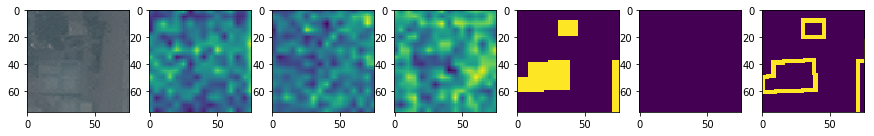

Epoch: 1 of: 1000 loss: 10448.1708984375


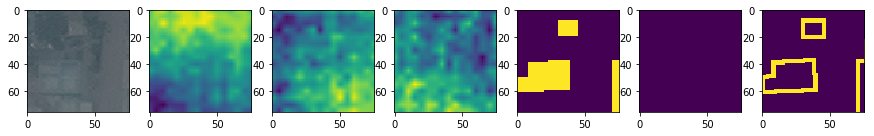

Epoch: 2 of: 1000 loss: 9884.0830078125


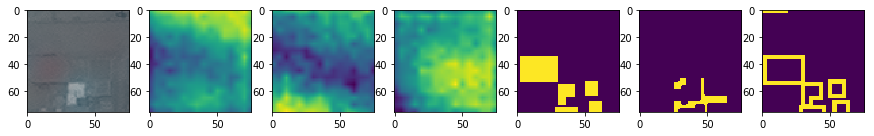

Epoch: 3 of: 1000 loss: 9212.787109375


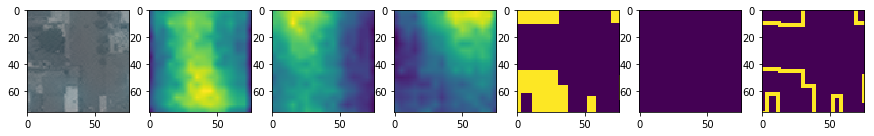

Epoch: 4 of: 1000 loss: 8596.7109375


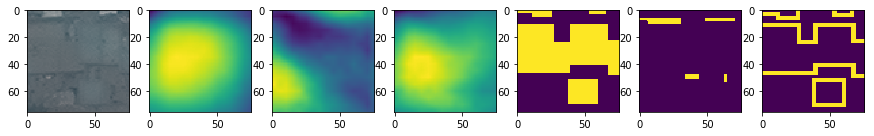

Epoch: 5 of: 1000 loss: 8293.6083984375


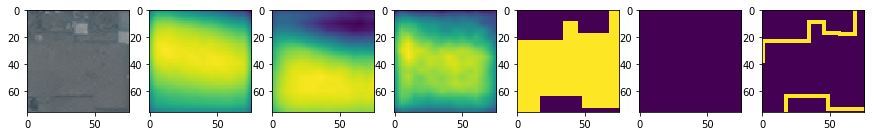

Epoch: 6 of: 1000 loss: 7988.36572265625


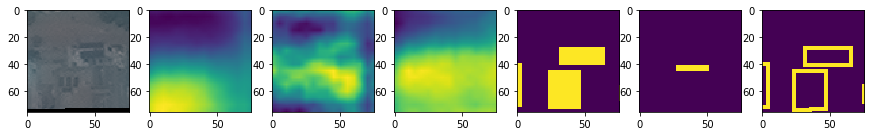

Epoch: 7 of: 1000 loss: 7655.37939453125


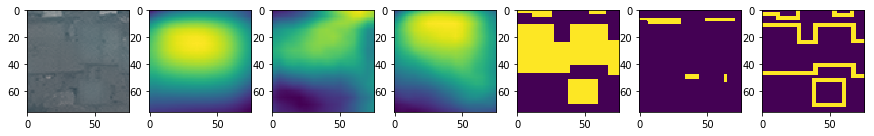

Epoch: 8 of: 1000 loss: 7401.431640625


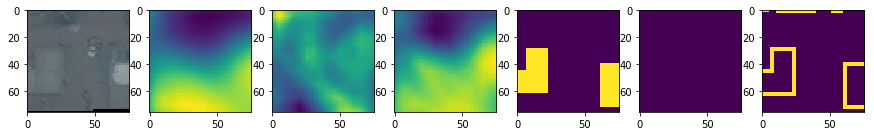

Epoch: 9 of: 1000 loss: 7389.2529296875


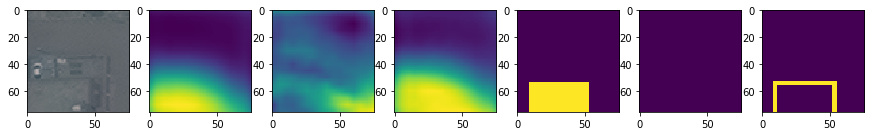

Epoch: 10 of: 1000 loss: 7111.615234375


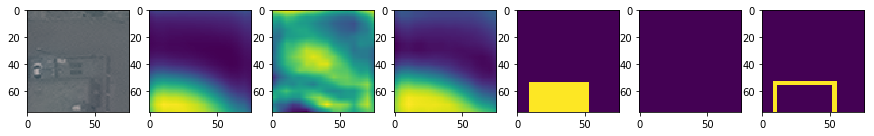

Epoch: 11 of: 1000 loss: 6791.72021484375


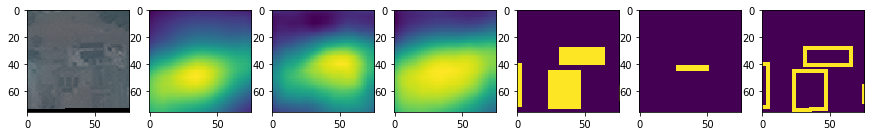

Epoch: 12 of: 1000 loss: 6591.26416015625


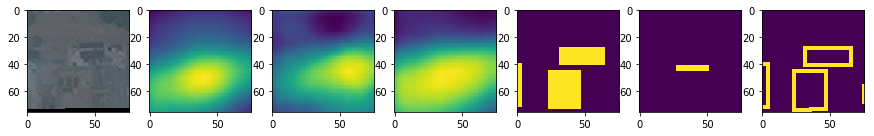

Epoch: 13 of: 1000 loss: 6384.833984375


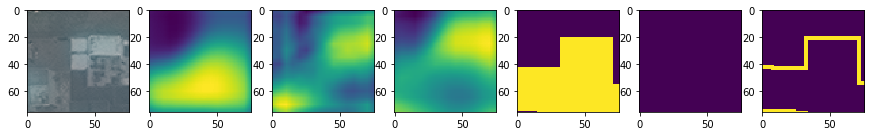

Epoch: 14 of: 1000 loss: 6175.66796875


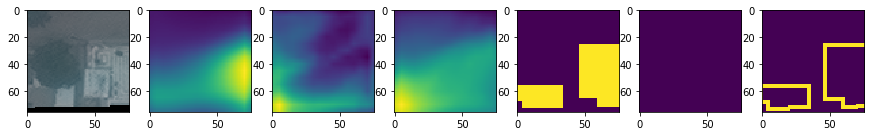

Epoch: 15 of: 1000 loss: 6002.50634765625


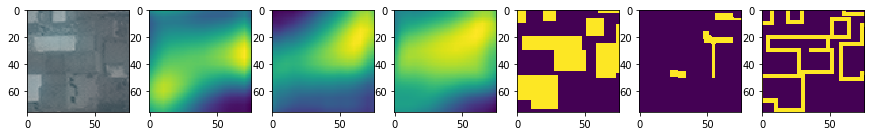

Epoch: 16 of: 1000 loss: 5931.02685546875


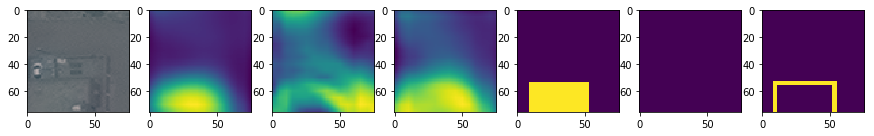

Epoch: 17 of: 1000 loss: 5787.7412109375


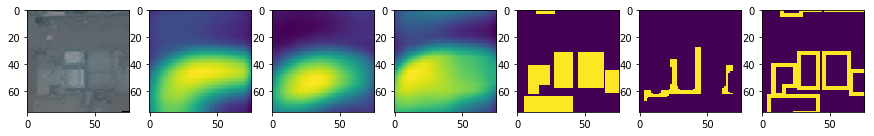

Epoch: 18 of: 1000 loss: 5722.87646484375


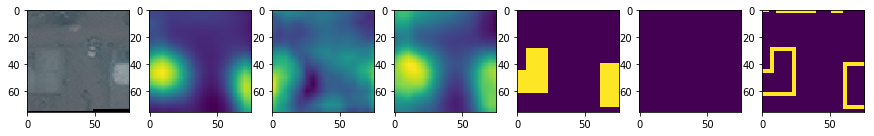

Epoch: 19 of: 1000 loss: 5600.60888671875


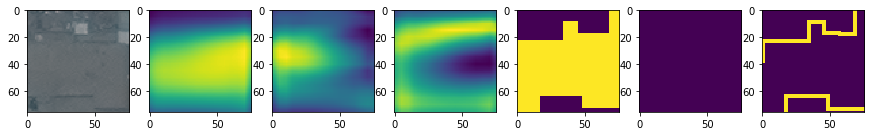

Epoch: 20 of: 1000 loss: 5404.13427734375


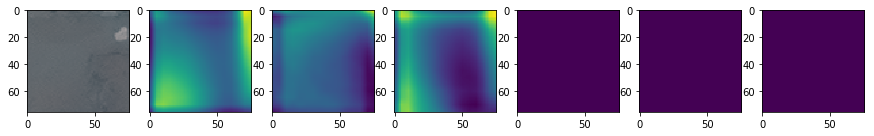

Epoch: 21 of: 1000 loss: 5295.83740234375


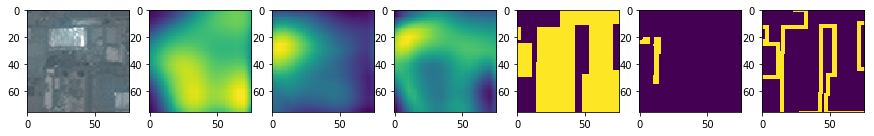

Epoch: 22 of: 1000 loss: 5110.32275390625


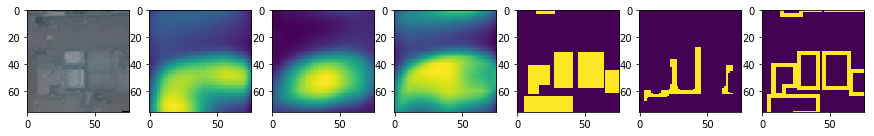

Epoch: 23 of: 1000 loss: 4990.47705078125


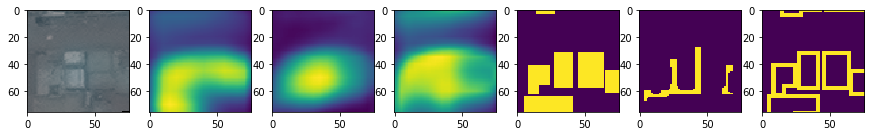

Epoch: 24 of: 1000 loss: 4991.95654296875


In [ ]:
iteration_count = 0
# For all epochs
for epoch in range(num_epochs):
    # Train step
    model.train()    
    # For all elements on the training set
    for i, (imgs, labels) in enumerate(dataloader_train):
        # Send inputs/labels to GPU                
        labels = labels.to(device)
        imgs = imgs.to(device)                
        
        optimizer.zero_grad()
        
        outputs = model(imgs)
        
        #loss_dice = dice_loss(outputs, labels)
        loss = loss_fn(outputs, labels)        
        
        loss.backward()
        optimizer.step()
        exp_lr_scheduler.step(epoch)
        writer.add_scalar('loss/', loss.item(), iteration_count)
        #writer.add_scalar('loss_dice/', loss_dice.item(), iteration_count)
        iteration_count+=1        
    print('Epoch:', epoch, 'of:', num_epochs, 'loss:', loss.item())
    # Get number of channels on output (Number of classes)
    num_channels_outputs = outputs.shape[1]
    
    # Send to tensorboard loss
    out_norm = sat_utils.img_minmax_norm_torch(outputs)
    labels_norm = sat_utils.img_minmax_norm_torch(labels)
    imgs_norm = sat_utils.img_minmax_norm_torch(imgs)
    writer.add_images('Image', imgs_norm, epoch)
    writer.add_images('out_mask', out_norm[:, 0, :, :].unsqueeze(1), epoch)
    writer.add_images('out_border', out_norm[:, 2, :, :].unsqueeze(1), epoch)
    writer.add_images('label_mask', labels_norm[:, 0, :, :].unsqueeze(1), epoch)
    writer.add_images('label_border', labels_norm[:, 2, :, :].unsqueeze(1), epoch)
    
    img_idx = randint(0, batch_size-1)
    img_input = imgs_norm[img_idx,:,:,:].cpu().numpy()
    f, axarr = plt.subplots(1, (num_channels_outputs*2) + 1, figsize=(15,15))
    axarr[0].imshow(np.moveaxis(img_input, 0, 2)) #4 With 8 channels
    axarr[1].imshow(outputs[img_idx,0,:,:].detach().cpu())
    axarr[2].imshow(outputs[img_idx,1,:,:].detach().cpu())
    axarr[3].imshow(outputs[img_idx,2,:,:].detach().cpu())
    #axarr[1].imshow(labels[img_idx,:,:].cpu())
    axarr[4].imshow(labels[img_idx,0,:,:].cpu())
    axarr[5].imshow(labels[img_idx,1,:,:].cpu())
    axarr[6].imshow(labels[img_idx,2,:,:].cpu())
    plt.show()
    

#### Test Model

In [ ]:
@interact(idx_img=widgets.IntSlider(min=0,max=tensor_x.shape[0]-1))
def testModel(idx_img):
    model.eval()
    with torch.no_grad():
        img = tensor_x[idx_img].unsqueeze(0).to(device)
        pred = model(img)
        
    img_numpy = img.cpu().squeeze().numpy()
    pred_numpy = pred.cpu().squeeze().numpy()
    label_numpy = tensor_y[idx_img].squeeze().numpy()
    
    #pred_numpy = np.tanh(pred_numpy)
    print(np.max(pred_numpy))
    print(np.min(pred_numpy))
    
    # Very very Naive way to threshold (We should use Gan here!)
    #threshold = (np.max(pred_numpy[0,:,:]) - np.min(pred_numpy[0,:,:])) / 2
    
    # Merge Mask and Border
    mask_border = pred_numpy[0,:,:] - pred_numpy[2,:,:]
    #mask_border = sigmoid(mask_border)
    
    f, axarr = plt.subplots(1, 5, figsize=(15,15))
    axarr[0].imshow(img_numpy[0,:,:]) #4 With 8 channels
    axarr[0].title.set_text('Original')
    axarr[1].imshow(pred_numpy[0,:,:])
    axarr[1].title.set_text('Prediction Mask')
    axarr[2].imshow(pred_numpy[2,:,:])
    axarr[2].title.set_text('Prediction Border')
    axarr[3].imshow(mask_border)
    axarr[3].title.set_text('Subtracted')
    axarr[4].imshow(label_numpy[0,:,:])
    axarr[4].title.set_text('Label')